In [1]:
cd /home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src


In [2]:
#cd /home/roberto/Desktop/romain_ic/wavemixing_project/src

In [3]:
import os
import sys

sys.path.insert(0, os.path.abspath("./post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("./helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("./file_manager"))
sys.path.insert(0, os.path.abspath("./hamiltonean_builder"))
sys.path.insert(0, os.path.abspath("./correlation"))
sys.path.insert(0, os.path.abspath("./single_and_double_excitations_subspace"))

In [4]:
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from hamiltonean_builder import *
from helper_functions.operators import *
from helper_functions.cloud import *
from file_manager.visualization_preparation_tools import *
from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_ODE import *
from single_and_double_excitations_subspace.QRT_dynamics_ODE import *

from post_processing.local_calculations import *
from helper_functions.cloud import *
from helper_functions.operators import *
from helper_functions.other import * 

In [5]:
N = 6
N_atoms = N

b0 = 0.1

repeat = False
if repeat == False:
    r = random_cloud(0, N, exc_radius = None, b0 = b0)
    
print(f"r1, r2 = np.array([{r[0][0]}, {r[0][1]}, {r[0][2]}]), np.array([{r[1][0]}, {r[1][1]}, {r[1][2]}]) ")

r1, r2 = np.array([[5.20581198], [0.88375048], [9.26170486]]), np.array([[2.60243746], [7.39088873], [-0.93690897]]) 


In [6]:
r1, r2 = np.array([[-5.15532159], [-1.01853261], [0.95664644]]), np.array([[-3.13364512], [-0.22723283], [2.54200667]]) 
#r = np.array([r1,r2])

### Subspace solutions

In [7]:
R1 = get_nhat_from_angle(25)
R2 = get_nhat_from_angle(205)

tf = 4.5
Omega = 0.5
Delta = 20
t_span, dt = np.linspace(0,tf,120, retstep = True) 

Exact:

In [8]:
taulist = t_span 

S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = None, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r)
rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  0, S_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)


g2_ls, rho_ss, total_time_ss, total_time_correlation = g2_l(S_H, 0, r, R1, R2, taulist, S_c_ops, N, faseglobal = 1, rho_ss = rho_ss_S, rho_ss_parameter = "direct", tmax = None)

sigma_ij = np.zeros([N,N], dtype="object")

S_sigmam_i_expectations = np.zeros(len(r), dtype = "object")
S_sigmam_ij_expectations = np.zeros((len(r),len(r)), dtype = "object")

for i in range(len(sigma_ij[0])):
    #one_time
    S_sigmam_i_expectations[i] = expect(rho_ss_S, sigmam_i(N, i)) 
    for j in range(len(sigma_ij[0])):
        #two_times
        sigma_ij[i][j] = (correlation_2op_1t(S_H, rho_ss, taulist, S_c_ops, sigmam_i(N,i), sigmam_i(N,j), solver='me', reverse=True)) 
        #one_time
        S_sigmam_ij_expectations[i][j] = expect(rho_ss_S, sigmam_i(N, i)*sigmam_i(N, j))


b0 system None
kd system None
r is an array


QRT

In [9]:
#remove to use full aproximated approach
#S_sigmam_ij_expectations= None
#S_sigmam_i_expectations = None

Delta1D, Omega1D, Gamma2D, Delta2D  = GetAllODEParametersGiven_r(Omega, Delta, r, scalar = True)
Beta1D, Beta2D, t_span, r = SolveForBeta1DandBeta2D_tau_QRT(N, kd = None , b0 = None, exc_radius = None, Delta = Delta , Omega = Omega, wave_mixing = True, scalar = True, interaction = True, r = r, taulist=t_span, Sm_1D = S_sigmam_i_expectations, Sm_2D = S_sigmam_ij_expectations )  

Plotting

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting 

Text(0, 0.5, '$ \\beta_{ij}(\\tau) =  \\langle \\sigma^-_i(t ) \\sigma^-_j(t + \\tau) \\rangle $')

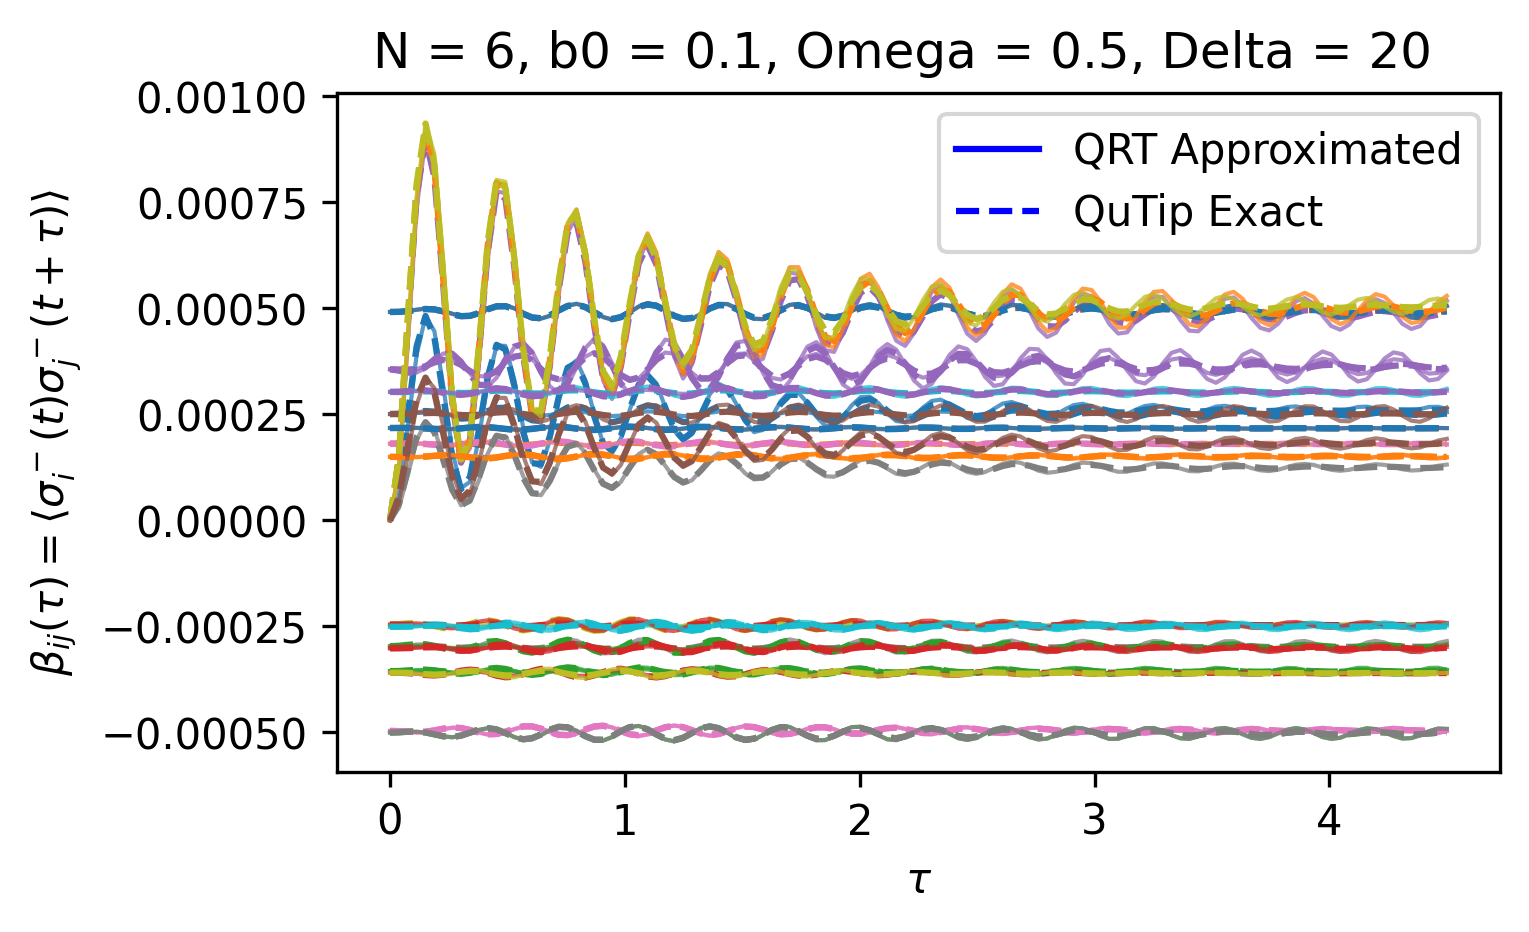

In [10]:
fig = plt.figure(figsize=(5, 3), dpi=300)
for i in range(len(r)):
    for j in range(len(r)):
        beta_plot = plt.plot(t_span, column(np.real(Beta2D), i, True, j),  linewidth = 1,  alpha = 0.75)
        color = beta_plot[0].get_color()
        sigma_scatter = plt.plot(t_span, sigma_ij[i][j], "--", color = color)

approximated_label = mlines.Line2D([], [], color='blue', marker='',
                          markersize=10, label='QRT Approximated')
exact_label = mlines.Line2D([], [], color='blue',
                          markersize=15, linestyle = "--",label='QuTip Exact')

plt.legend(handles=[approximated_label,exact_label])#, bbox_to_anchor=(0.43,-0.15))

plt.title(f"N = {N}, b0 = {b0}, Omega = {Omega}, Delta = {Delta}  ")
plt.xlabel(r"$\tau$")

plt.ylabel(r"$ \beta_{ij}(\tau) =  \langle \sigma^-_i(t ) \sigma^-_j(t + \tau) \rangle $")


Second correlation

In [11]:
g2_ls, rho_ss, total_time_ss, total_time_correlation = g2_l(S_H, 0, r, R1, R2, taulist, S_c_ops, N, faseglobal = 1, rho_ss = rho_ss_S, rho_ss_parameter = "direct", tmax = None)

In [12]:
g2_list = np.zeros_like(t_span)
for t in range(len(t_span)):
        g2_list[t] = np.real(g2_of_zero_subspace_approach(r, R1, R2, Beta1D[t], Beta2D[t]))

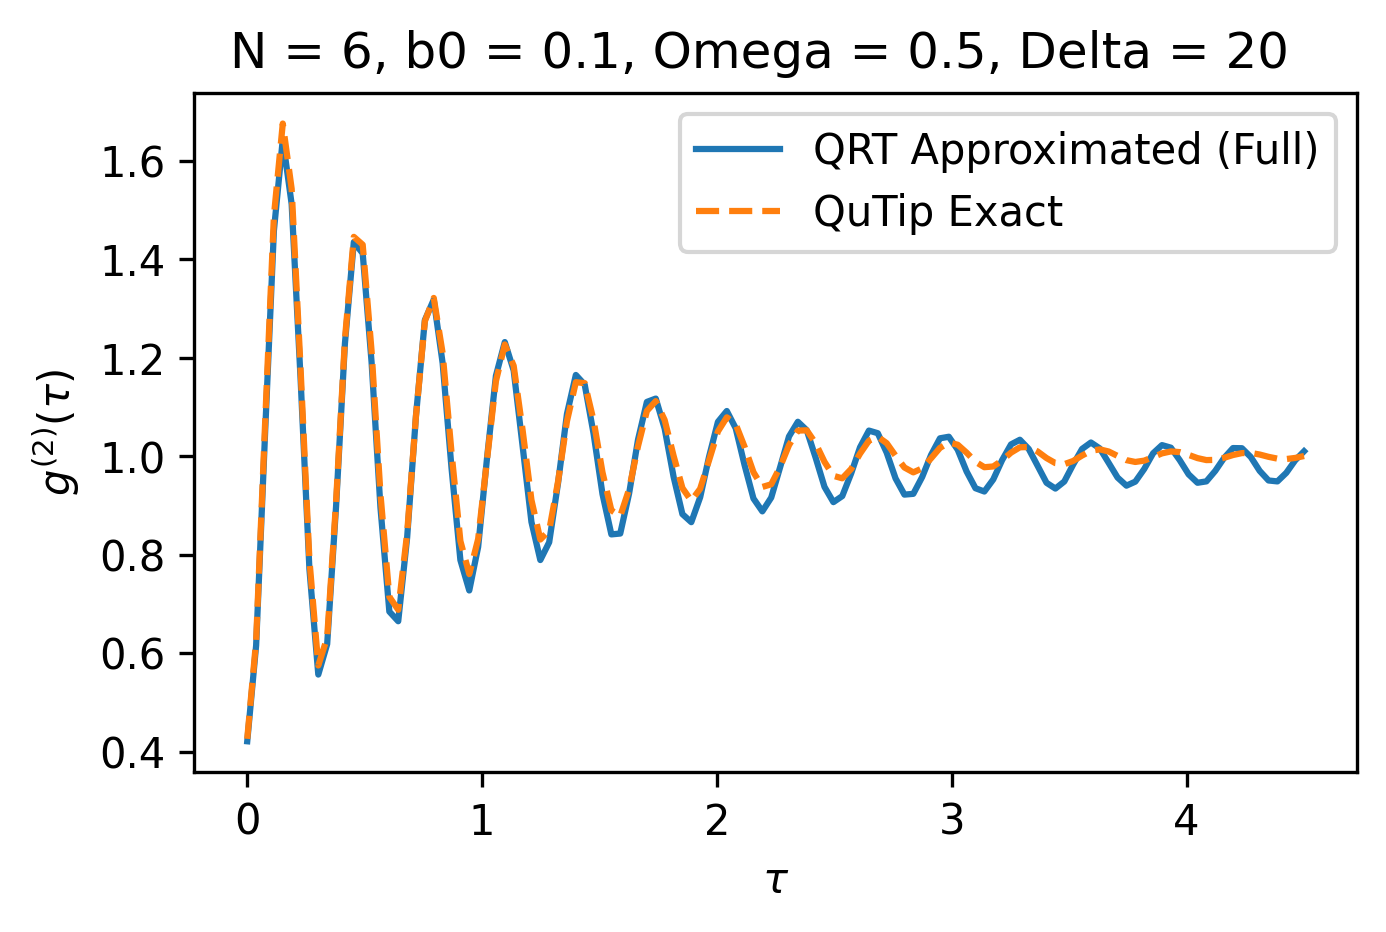

In [13]:
fig = plt.figure(figsize=(5, 3), dpi=300)
#plt.ylim(-0.2,14)
plt.plot(t_span, g2_list, label = 'QRT Approximated (Full)')
plt.plot(t_span, g2_ls, "--", label = "QuTip Exact")
plt.title(f"N = {N}, b0 = {b0}, Omega = {Omega}, Delta = {Delta}  ")

plt.xlabel(r"$\tau$")
plt.ylabel(r"$ g^{(2)}(\tau)  $")
plt.legend()

In [14]:
np.average(g2_list-g2_ls)

-0.0169086132052162

In [15]:
print("Approximated", g2_list[-1])
print("Exact", g2_ls[-1])

Approximated 1.0100370804974936
Exact 1.0004052819148295


/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparation_tools.py:342: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src/file_manager/visualization_preparat

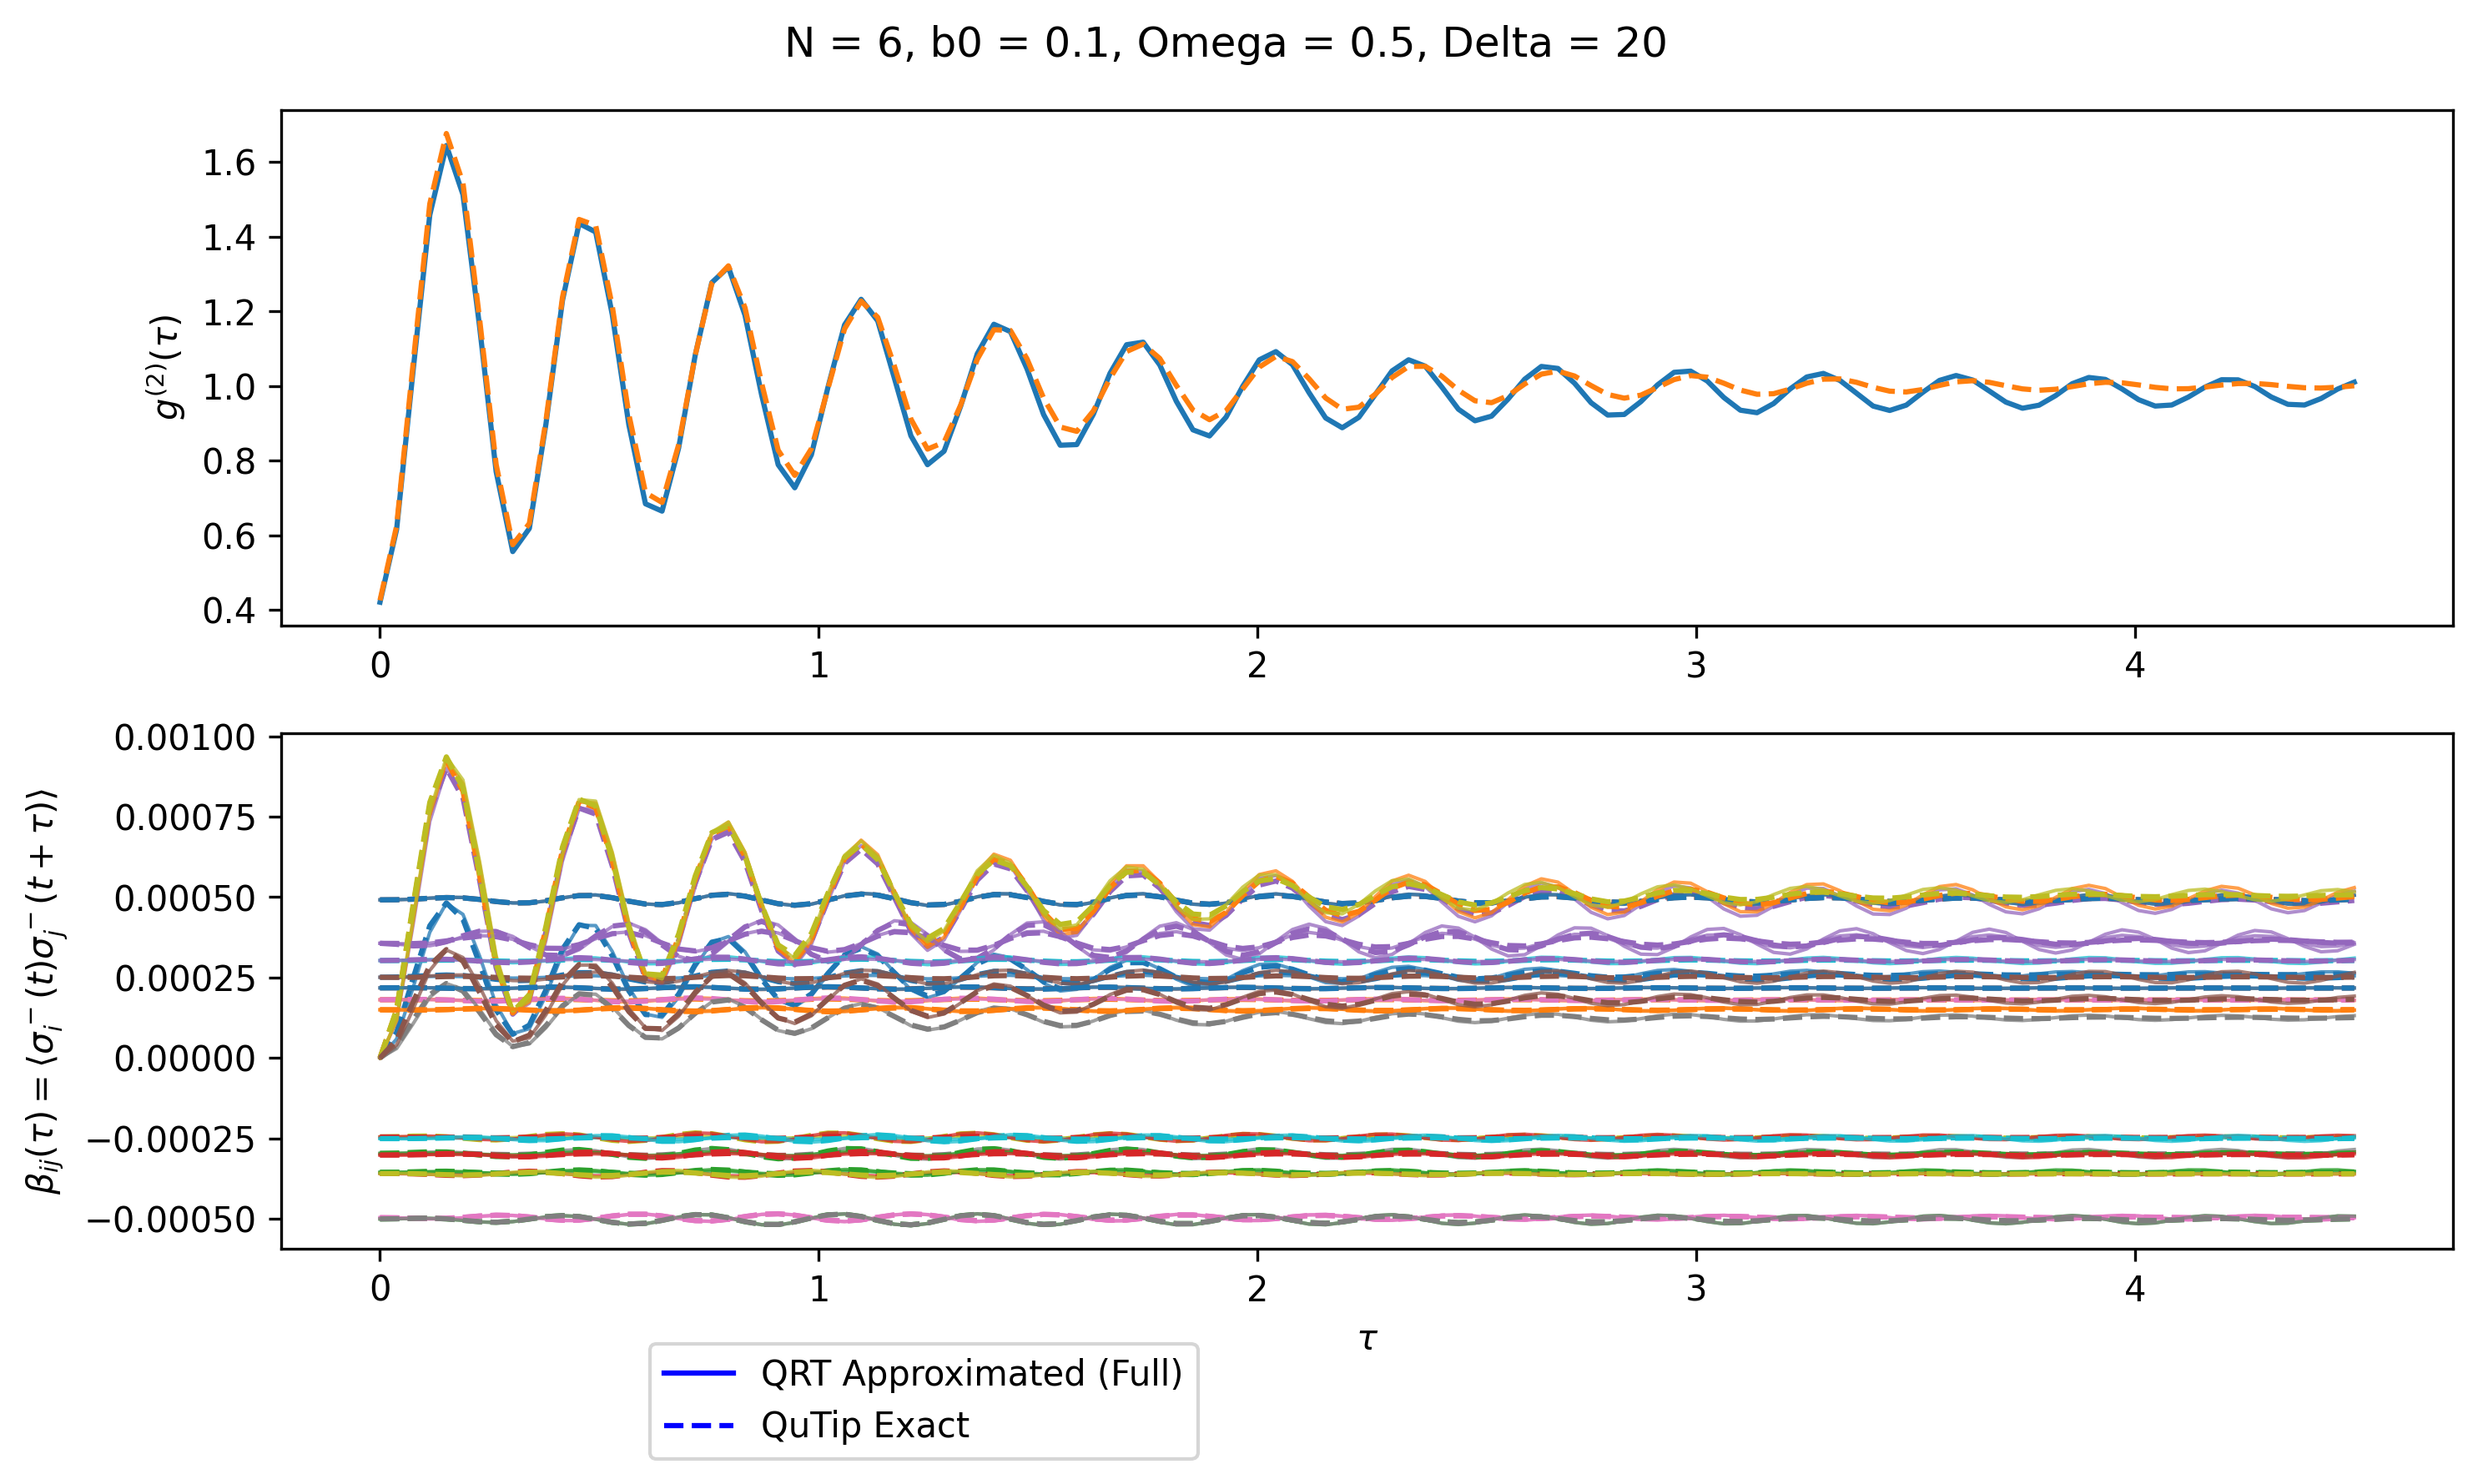

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), dpi=300)
ax1.plot(t_span, g2_list, label = 'QRT Approximated')
ax1.plot(t_span, g2_ls, "--", label = "QuTip Exact")
plt.suptitle(f"N = {N}, b0 = {b0}, Omega = {Omega}, Delta = {Delta}  ")

#ax1.set_xlabel(r"$\tau$")
ax1.set_ylabel(r"$ g^{(2)}(\tau)  $")



for i in range(len(r)):
    for j in range(len(r)):
        beta_plot = ax2.plot(t_span, np.real(column((Beta2D), i, True, j)),  linewidth = 1,  alpha = 0.75)
        color = beta_plot[0].get_color()
        sigma_scatter = ax2.plot(t_span, np.real(sigma_ij[i][j]), "--", color = color)

approximated_label = mlines.Line2D([], [], color='blue', marker='',
                          markersize=10, label='QRT Approximated (Full)')
exact_label = mlines.Line2D([], [], color='blue',
                          markersize=15, linestyle = "--",label='QuTip Exact')


ax2.set_xlabel(r"$\tau$")

ax2.set_ylabel(r"$ \beta_{ij}(\tau) =  \langle \sigma^-_i(t ) \sigma^-_j(t + \tau) \rangle $")


ax2.legend(handles=[approximated_label,exact_label], bbox_to_anchor=(0.43,-0.15))#, 
#ax1.legend()

plt.savefig(f"./benchmarking/g2_exactQRT_run{str(sigma_ij[0][0][1])[6:8]}.jpg")
fig.tight_layout()

In [17]:
print( "Average Error",np.abs(np.average(g2_list-g2_ls)))

Average Error 0.0169086132052162
